In [7]:
from openptv_python.calibration import Calibration
from openptv_python.parameters import ControlPar, VolumePar
from openptv_python.trafo import pixel_to_metric, dist_to_flat, metric_to_pixel
from openptv_python.multimed import ray_tracing, move_along_ray
from openptv_python.imgcoord import img_coord
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [23]:
def openptv_project_XYZ_on_camera(XYZ, cal, cpar):
    """ Projects 3D points vector XYZ on camera defined by cal, cpar """
    xy = np.empty((XYZ.shape[0],2))
    for i, point in enumerate(XYZ):
        x, y = img_coord(point, cal, cpar.mm)
        x, y = metric_to_pixel(x, y, cpar)
        xy[i,0] = x
        xy[i,1] = y
    return xy

In [24]:
# Read the required stuff from the working folder
import pathlib, os, sys
working_path = pathlib.Path('OpenPTV_LineOfSight')

camera_1_calibration = Calibration().from_file(os.path.join(working_path,"calibration","cam1.tif.ori"), None)
control_parameters = ControlPar().from_file(os.path.join(working_path,"parameters","ptv.par"))
volume_parameters = VolumePar().from_file(os.path.join(working_path,"parameters","criteria.par"))

No addpar file found. Using default values for radial distortion


In [25]:
sys.path.append('proPTV_LineOfSight')
from generateBody import *
from func import *

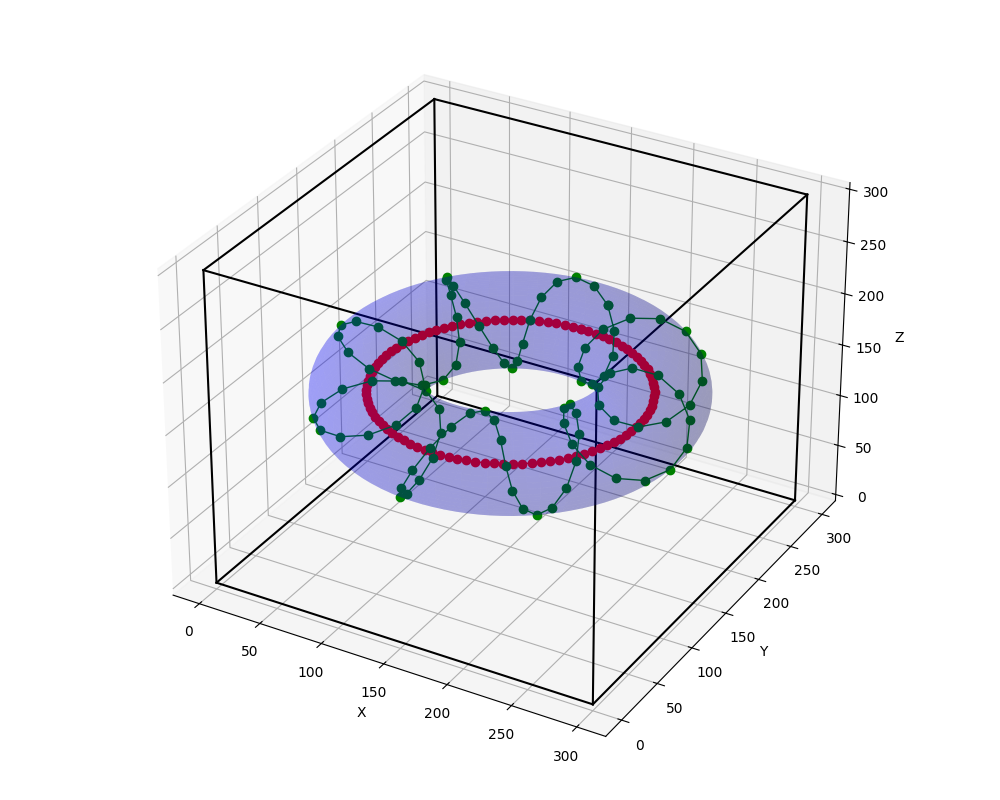

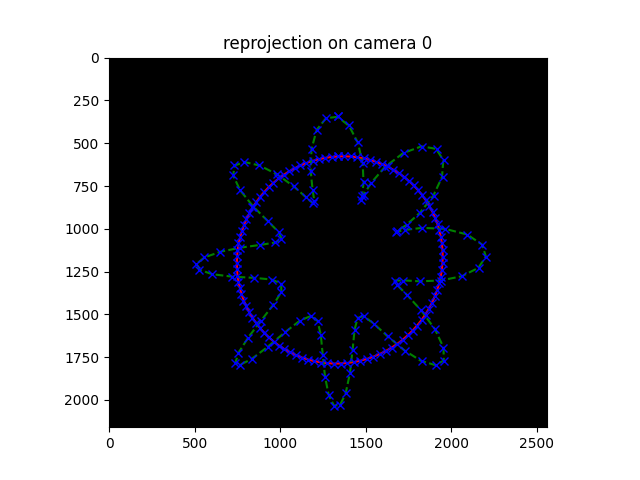

In [30]:
# def project_body(parent_path):
# user defined parameter
parent_path = 'proPTV_LineOfSight'
calibration_path = os.path.join(parent_path, "calibration/c{cam}/soloff_c{cam}{xy}.txt")
c = 0 # camera ID

# load calibration of camera c
ax, ay = np.loadtxt(calibration_path.format(cam=c,xy="x"),delimiter=','), np.loadtxt(calibration_path.format(cam=c,xy="y"),delimiter=',')

# estimate the 3d body 
torus, mid, spiral = Torus(100, 40, 100, 8, 150, np.pi/2, np.array([0,0,1]))
X,Y,Z = torus
X_mid,Y_mid,Z_mid = mid
X_spiral,Y_spiral,Z_spiral = spiral

# estimate projection of the lines in camera c
xy_mid = np.vstack([F(np.vstack([X_mid,Y_mid,Z_mid]).T,ax),F(np.vstack([X_mid,Y_mid,Z_mid]).T,ay)]).T
xy_spiral = np.vstack([F(np.vstack([X_spiral,Y_spiral,Z_spiral]).T,ax),F(np.vstack([X_spiral,Y_spiral,Z_spiral]).T,ay)]).T


# project points on OpenPTV camera 1 which is c = 0 for proPTV 
xy_mid_optv = openptv_project_XYZ_on_camera(np.vstack([X_mid,Y_mid,Z_mid]).T, camera_1_calibration, control_parameters)
xy_spiral_optv = openptv_project_XYZ_on_camera(np.vstack([X_spiral,Y_spiral,Z_spiral]).T, camera_1_calibration, control_parameters)

# make 3D figure
axis = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
axis.set_xlabel('X'), axis.set_ylabel('Y'), axis.set_zlabel('Z')
# plot box
axis.plot([0,300],[0,0],[0,0],c='black'), axis.plot([0,0],[0,300],[0,0],c='black'), axis.plot([0,0],[0,0],[0,300],c='black')
axis.plot([300,300],[0,300],[0,0],c='black'), axis.plot([300,300],[0,0],[0,300],c='black'), axis.plot([0,300],[300,300],[0,0],c='black')
axis.plot([0,0],[300,300],[0,300],c='black'), axis.plot([0,300],[0,0],[300,300],c='black'), axis.plot([0,0],[0,300],[300,300],c='black')
axis.plot([300,300],[300,300],[0,300],c='black'), axis.plot([300,300],[0,300],[300,300],c='black'), axis.plot([0,300],[300,300],[300,300],c='black')
# plot torus
axis.plot_surface(X, Y, Z, color='b', alpha=0.2)
axis.plot(X_mid,Y_mid,Z_mid,'o-', color='red', linewidth=1)
axis.plot(X_spiral,Y_spiral,Z_spiral,'o-', color='green', linewidth=1)
plt.tight_layout(), plt.show()   

# make projection of lines in cam c
plt.figure()
plt.title('reprojection on camera ' + str(c))
plt.imshow(np.zeros([2160,2560]),cmap='gray')

plt.plot(xy_mid[:,0],xy_mid[:,1],'-',c='red')
plt.plot(xy_spiral[:,0],xy_spiral[:,1],'--',c='green')

plt.plot(xy_mid_optv[:,0],xy_mid_optv[:,1],'x',c='blue')
plt.plot(xy_spiral_optv[:,0],xy_spiral_optv[:,1],'x',c='blue')

plt.show()